In [1]:
from pylab import *
# import nylib, nylib2, cjlib
import bloch

In [2]:
# simulate 4 Z-spectra with different saturation paramters
# glutamate, PCr, APT, Cr

field = 7.0
TR = 7.0

cestFreq = linspace(-6,6,101)

satPulse = zeros((1, 3))
satPulse[0,0] = 0
satPulse[0,1] = 2.*42.57
satPulse[0,2] = 4

pulse_powers = linspace(0.0, 4.1, 41)
pulse_durations = linspace(0.0, 4.1, 41)

peak_locations = r_[3.0, 2.6, 3.5, 2.0]


# # define pools

freewater = bloch.Pool('freewater', t1 = 1.6, t2 = 0.062, lifetime = 1., chemical_shift = -0.0001, concentration = 111200)
macromolecular = bloch.Pool('macromolecular', t1 = 1, t2 = 9e-6, lifetime = 1/40., chemical_shift = 0.0001, concentration = 5500.)
amide = bloch.Pool('amide', t1 = 1, t2 = 0.1, lifetime = 1/30., chemical_shift = 3.5, concentration = 72.)
amine = bloch.Pool('amine', t1 = 1, t2 = 0.2, lifetime = 1/5500., chemical_shift = 3.0, concentration = 20.)
guanidinium = bloch.Pool('guanidinium', t1 = 1, t2 = 0.17, lifetime = 1/1100., chemical_shift = 2.0, concentration = 20.)
# pcr_1 = bloch.Pool('pcr_1', t1 = 1, t2 = 0.1, lifetime = 1/120., chemical_shift = 1.95, concentration = 10.)
pcr_2 = bloch.Pool('pcr_2', t1 = 1, t2 = 0.1, lifetime = 1/260., chemical_shift = 2.6, concentration = 10.)
hydroxyl = bloch.Pool('hydroxyl', t1 = 1, t2 = 0.055, lifetime = 1/2000., chemical_shift = 0.9, concentration = 45.)
noe_1 = bloch.Pool('noe_1', t1 = 1, t2 = 0.005, lifetime = 1/20., chemical_shift = -3.5, concentration = 100.)

pools_baseline = (freewater, amide, amine, guanidinium, pcr_2, hydroxyl, noe_1, macromolecular)
pools_glu =      (freewater, amide, guanidinium, pcr_2, hydroxyl, noe_1, macromolecular)
pools_pcr =      (freewater, amide, amine, guanidinium, hydroxyl, noe_1, macromolecular)
pools_apt =      (freewater, amine, guanidinium, pcr_2, hydroxyl, noe_1, macromolecular)
pools_cr =       (freewater, amide, amine, pcr_2, hydroxyl, noe_1, macromolecular)

labels = ['baseline', 'glu', 'pcr', 'apt', 'cr']


In [3]:
cest_diff_sat_power = zeros((len(labels), len(pulse_powers)))
cest_diff_sat_durs = zeros((len(labels), len(pulse_durations)))
simulationMatrix_power = zeros((len(labels), len(pulse_powers), len(cestFreq)))
simulationMatrix_duration = zeros((len(labels), len(pulse_durations), len(cestFreq)))
   


# all the pools

In [4]:
simulationMatrix = zeros((len(labels), len(pulse_powers), len(pulse_durations), len(cestFreq)))
for ik in range(simulationMatrix.shape[0]):
    print (ik)
    pools = eval('pools_%s'%labels[ik])
    # p = nylib.ProgressBar(simulationMatrix_glu.shape[0]-1)
    for ii in range(simulationMatrix.shape[1]):
    #     p.animate(ii)
        for ij in range(simulationMatrix.shape[2]):
            satPulse[0,1] = pulse_powers[ii]*42.57
            satPulse[0,2] = pulse_durations[ij]
            simulationMatrix[ik, ii, ij] = bloch.solve(pools, cestFreq, satPulse, crusher=False, magnetic_field=field,pulse_repeat = 1, post_dynamic_delay=TR-satPulse[0,2])[2*len(pools),:,-1]

0
1
2
3
4


In [5]:
save_dir = '/Volumes/T7/CEST_labeling/data/'
from scipy.io import savemat
savemat(save_dir + 'simulationMatrix_B1_tsat_7T_20210215.mat', {'Data':simulationMatrix})


In [4]:
save_dir = '/Volumes/T7/CEST_labeling/data/'
from scipy.io import loadmat
simulationMatrix_save=loadmat(save_dir + 'simulationMatrix_B1_tsat_7T_20210215.mat')['Data']


pulse_powers = linspace(0.0, 4.1, 41)
pulse_durations = linspace(0.0, 4.1, 41)

simulationMatrix = simulationMatrix_save
simulationMatrix.shape

pulse_powers = pulse_powers
pulse_durations = pulse_durations

In [5]:
# new matrix with the signal differences
differenceMatrix = zeros((simulationMatrix.shape[0]-1, simulationMatrix.shape[1], simulationMatrix.shape[2], simulationMatrix.shape[3]))
for ik in range(differenceMatrix.shape[0]):
    differenceMatrix[ik] = simulationMatrix[ik+1] - simulationMatrix[0]
    

In [6]:
# integrate each difference spectrum for the given region
peak_locations = r_[3.0, 2.6, 3.5, 2.0]
max_contrast = zeros((differenceMatrix.shape[0], differenceMatrix.shape[1], differenceMatrix.shape[2]))
for ii in range(max_contrast.shape[0]):
    for ij in range(max_contrast.shape[1]):
        for ik in range(max_contrast.shape[2]):
            sig_ints = where((cestFreq < peak_locations[ii]+0.2)&(cestFreq > peak_locations[ii]-0.2))[0]
            max_contrast[ii, ij, ik] = max(differenceMatrix[ii, ij, ik, sig_ints])

# glutamate

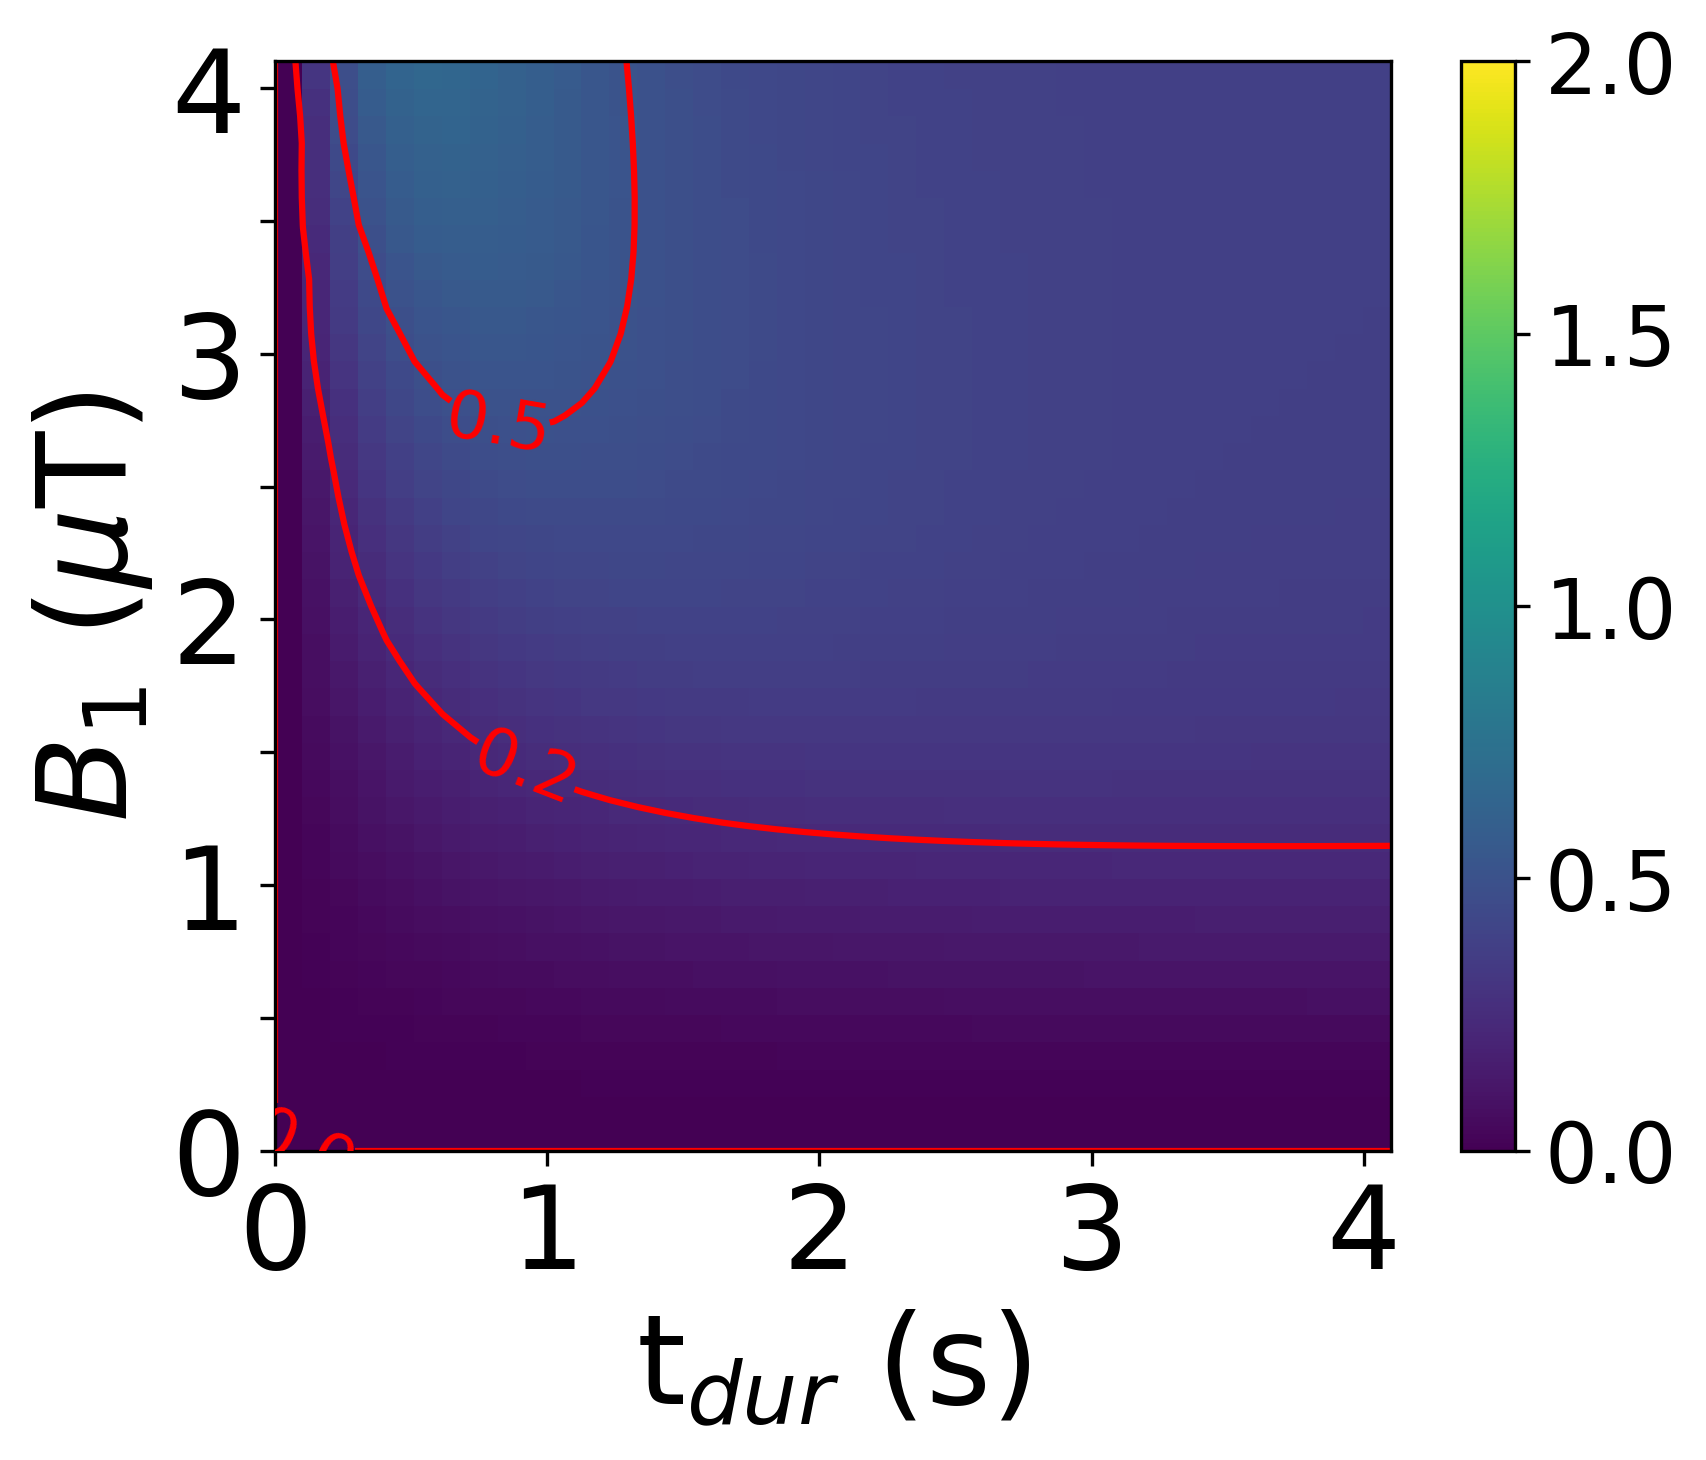

In [7]:
# contourf(X, Y, max_contrast[2], 5, cmap='RdGy')
fig, ax = plt.subplots(figsize=(6,4.81),dpi=300)

X=pulse_durations
Y=pulse_powers

contours = plt.contour(X, Y, 100*max_contrast[0], 2, colors='r')
plt.clabel(contours, inline=True, fmt='%1.1f',fontsize=16)

im = ax.pcolormesh(X, Y, 100*max_contrast[0],  vmin=0, vmax=2)
cbar = fig.colorbar(im, ticks=[0, 0.5, 1, 1.5, 2])
cbar.ax.tick_params(labelsize=20) 
# cbar.set_label('CEST contrast (%)', fontsize=20)

y_label_list = ['0','','1','','2','','3','','4']
ax.set_yticklabels(y_label_list, fontsize=28)


x_label_list = ['0','1','2','3','4']
ax.set_xticklabels(x_label_list, fontsize=28)

plt.ylabel('$B$$_{1}}$ ($\mu$T)', fontsize=30)
plt.xlabel('t$_{dur}}$ (s)', fontsize=30)
# plt.title('saturation efficiency ($\\alpha$)', fontsize=25)
# l(r'$\lambda$')

plt.show()


In [8]:
# fig,ax0 = plt.subplots(figsize=(5,4), dpi=300)

# ax0.plot(cestFreq,simulationMatrix[0,10,39,:],'k-',linewidth=3, label='with interested signal')
# ax0.plot(cestFreq,simulationMatrix[1,10,39,:],'b-',linewidth=3, label='without interested signal')

# ax0.set_xlim(cestFreq.max(), cestFreq.min())
# ax0.set_ylim(0.6,1.)
# ax0.set_ylabel('S$_s$$_a$$_t$/S$_0$', Fontsize = 20)
# ax0.tick_params(labelsize=15)
# ax0.set_xlabel('Saturation Frequency (ppm)', fontsize = 20)
# # legend(framealpha=0.0)

# ax1=ax0.twinx()
# ax1.plot(cestFreq, differenceMatrix[0,10,39,:]*100,'r-',linewidth=3, label='differencce')
    
# ax1.set_xlim(cestFreq.max(), cestFreq.min())
# ax1.set_ylim(0, 8)
# ax1.set_xlabel('Saturation Frequency (ppm)', fontsize = 20)
# ax1.set_ylabel('Signal (%)', Fontsize = 20)
# ax1.tick_params(labelsize=15)            
# # legend(framealpha=0.0)

# PCr

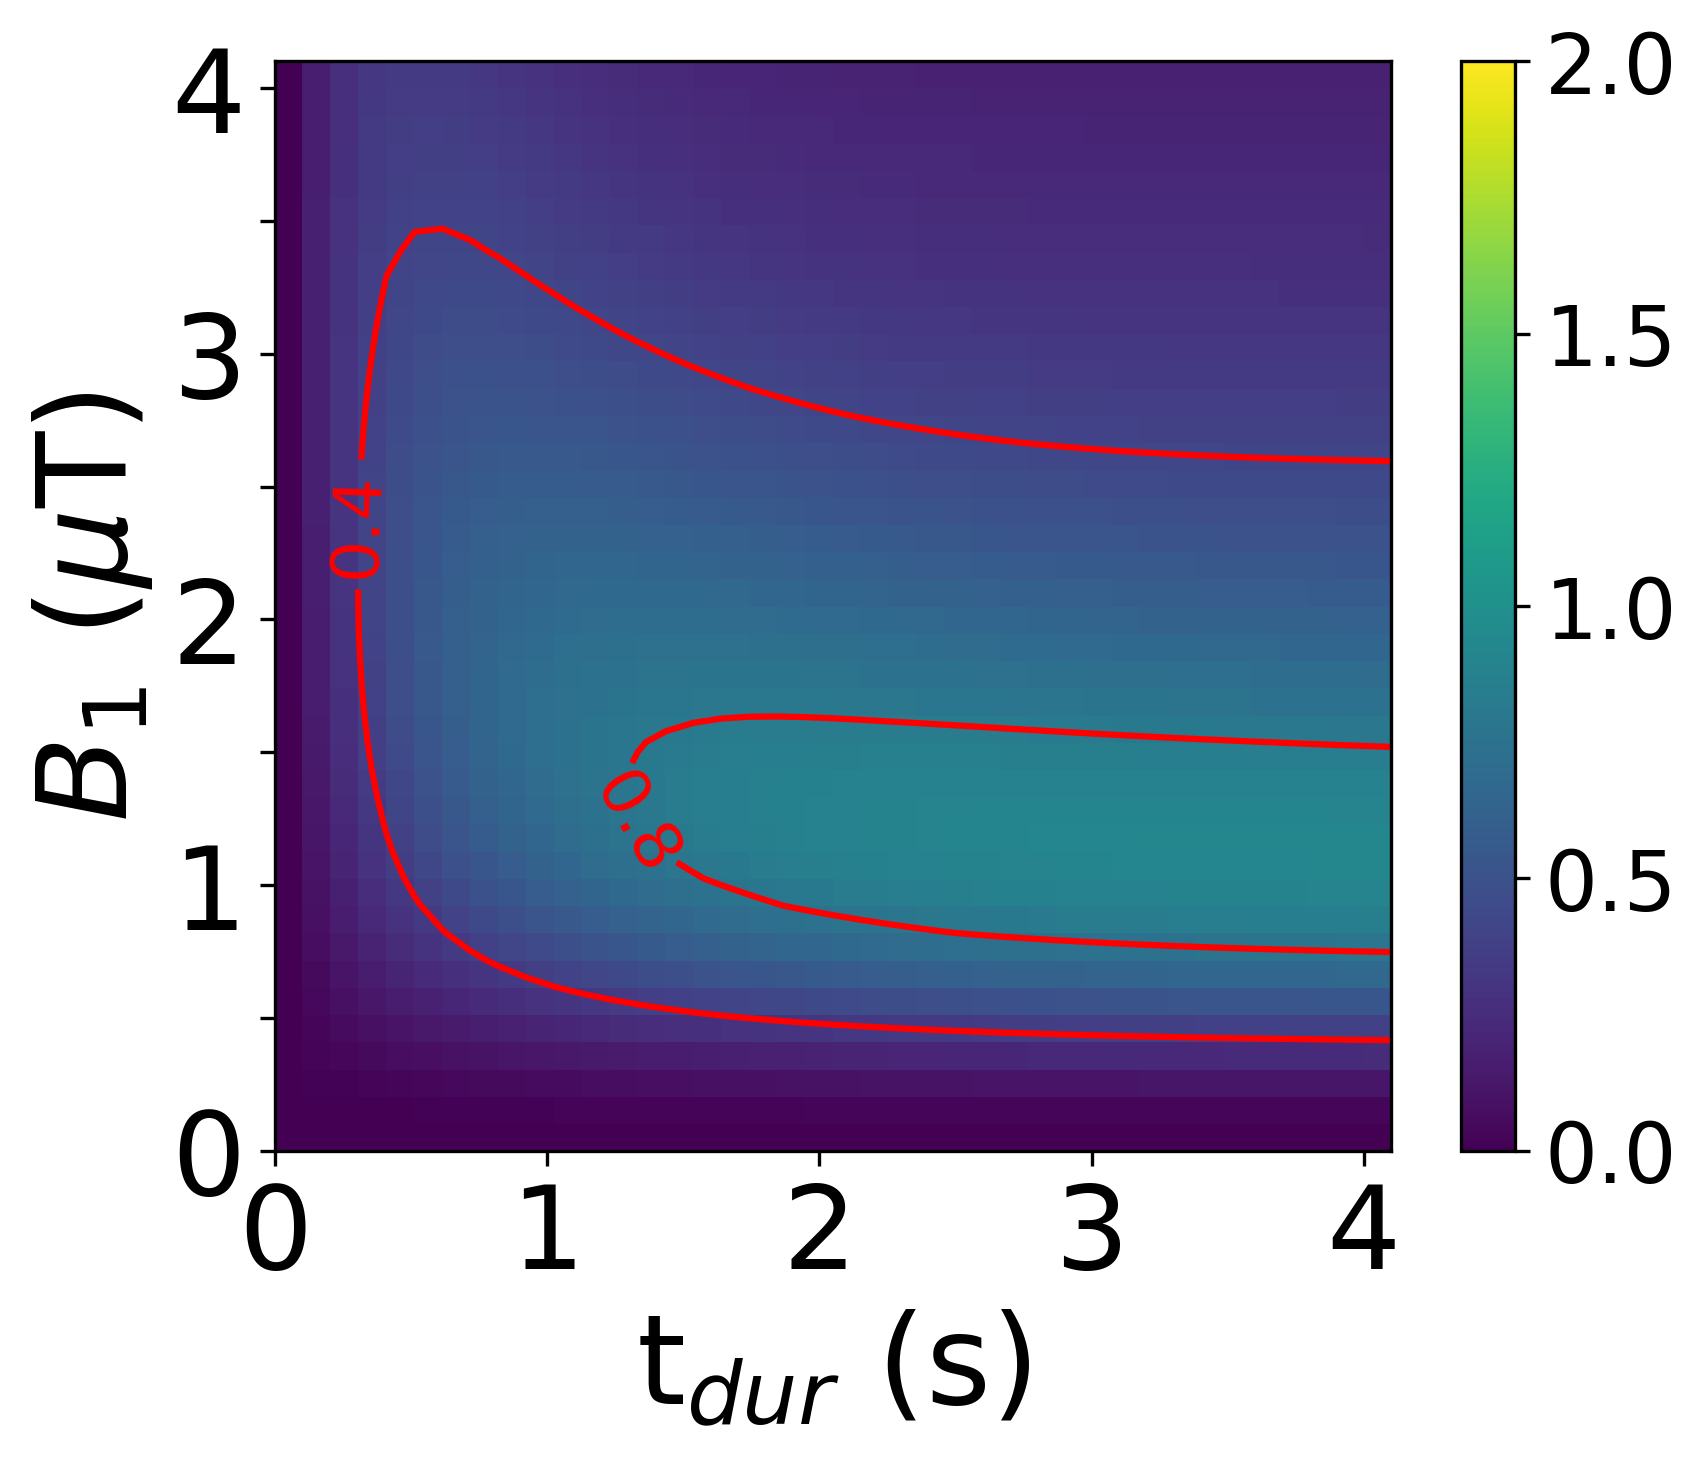

In [9]:
# contourf(X, Y, max_contrast[2], 5, cmap='RdGy')
fig, ax = plt.subplots(figsize=(6,4.81),dpi=300)


contours = plt.contour(X, Y, 100*max_contrast[1], 2, colors='r')
plt.clabel(contours, inline=True, fmt='%1.1f',fontsize=16)

im = ax.pcolormesh(X, Y, 100*max_contrast[1],  vmin=0, vmax=2)
cbar = fig.colorbar(im, ticks=[0, 0.5, 1, 1.5, 2])
cbar.ax.tick_params(labelsize=20) 
# cbar.set_label('CEST contrast (%)', fontsize=20)

y_label_list = ['0','','1','','2','','3','','4']
ax.set_yticklabels(y_label_list, fontsize=28)


x_label_list = ['0','1','2','3','4']
ax.set_xticklabels(x_label_list, fontsize=28)

plt.ylabel('$B$$_{1}}$ ($\mu$T)', fontsize=30)
plt.xlabel('t$_{dur}}$ (s)', fontsize=30)
# plt.title('saturation efficiency ($\\alpha$)', fontsize=25)
# l(r'$\lambda$')

plt.show()


In [11]:
# fig,ax0 = plt.subplots(figsize=(5,4), dpi=300)

# ax0.plot(cestFreq,simulationMatrix[2,10,10,:],'k-',linewidth=3, label='with interested signal')
# ax0.plot(cestFreq,simulationMatrix[2,10,39,:],'b-',linewidth=3, label='without interested signal')

# ax0.set_xlim(cestFreq.max(), cestFreq.min())
# ax0.set_ylim(0,1.)
# ax0.set_ylabel('S$_s$$_a$$_t$/S$_0$', Fontsize = 20)
# ax0.tick_params(labelsize=15)
# ax0.set_xlabel('Saturation Frequency (ppm)', fontsize = 20)
# # legend(framealpha=0.0)

# ax1=ax0.twinx()
# ax1.plot(cestFreq, differenceMatrix[1,10,39,:]*100,'r-',linewidth=3, label='differencce')
    
# ax1.set_xlim(cestFreq.max(), cestFreq.min())
# ax1.set_ylim(0, 8)
# ax1.set_xlabel('Saturation Frequency (ppm)', fontsize = 20)
# ax1.set_ylabel('Signal (%)', Fontsize = 20)
# ax1.tick_params(labelsize=15)            
# # legend(framealpha=0.0)

# Amide

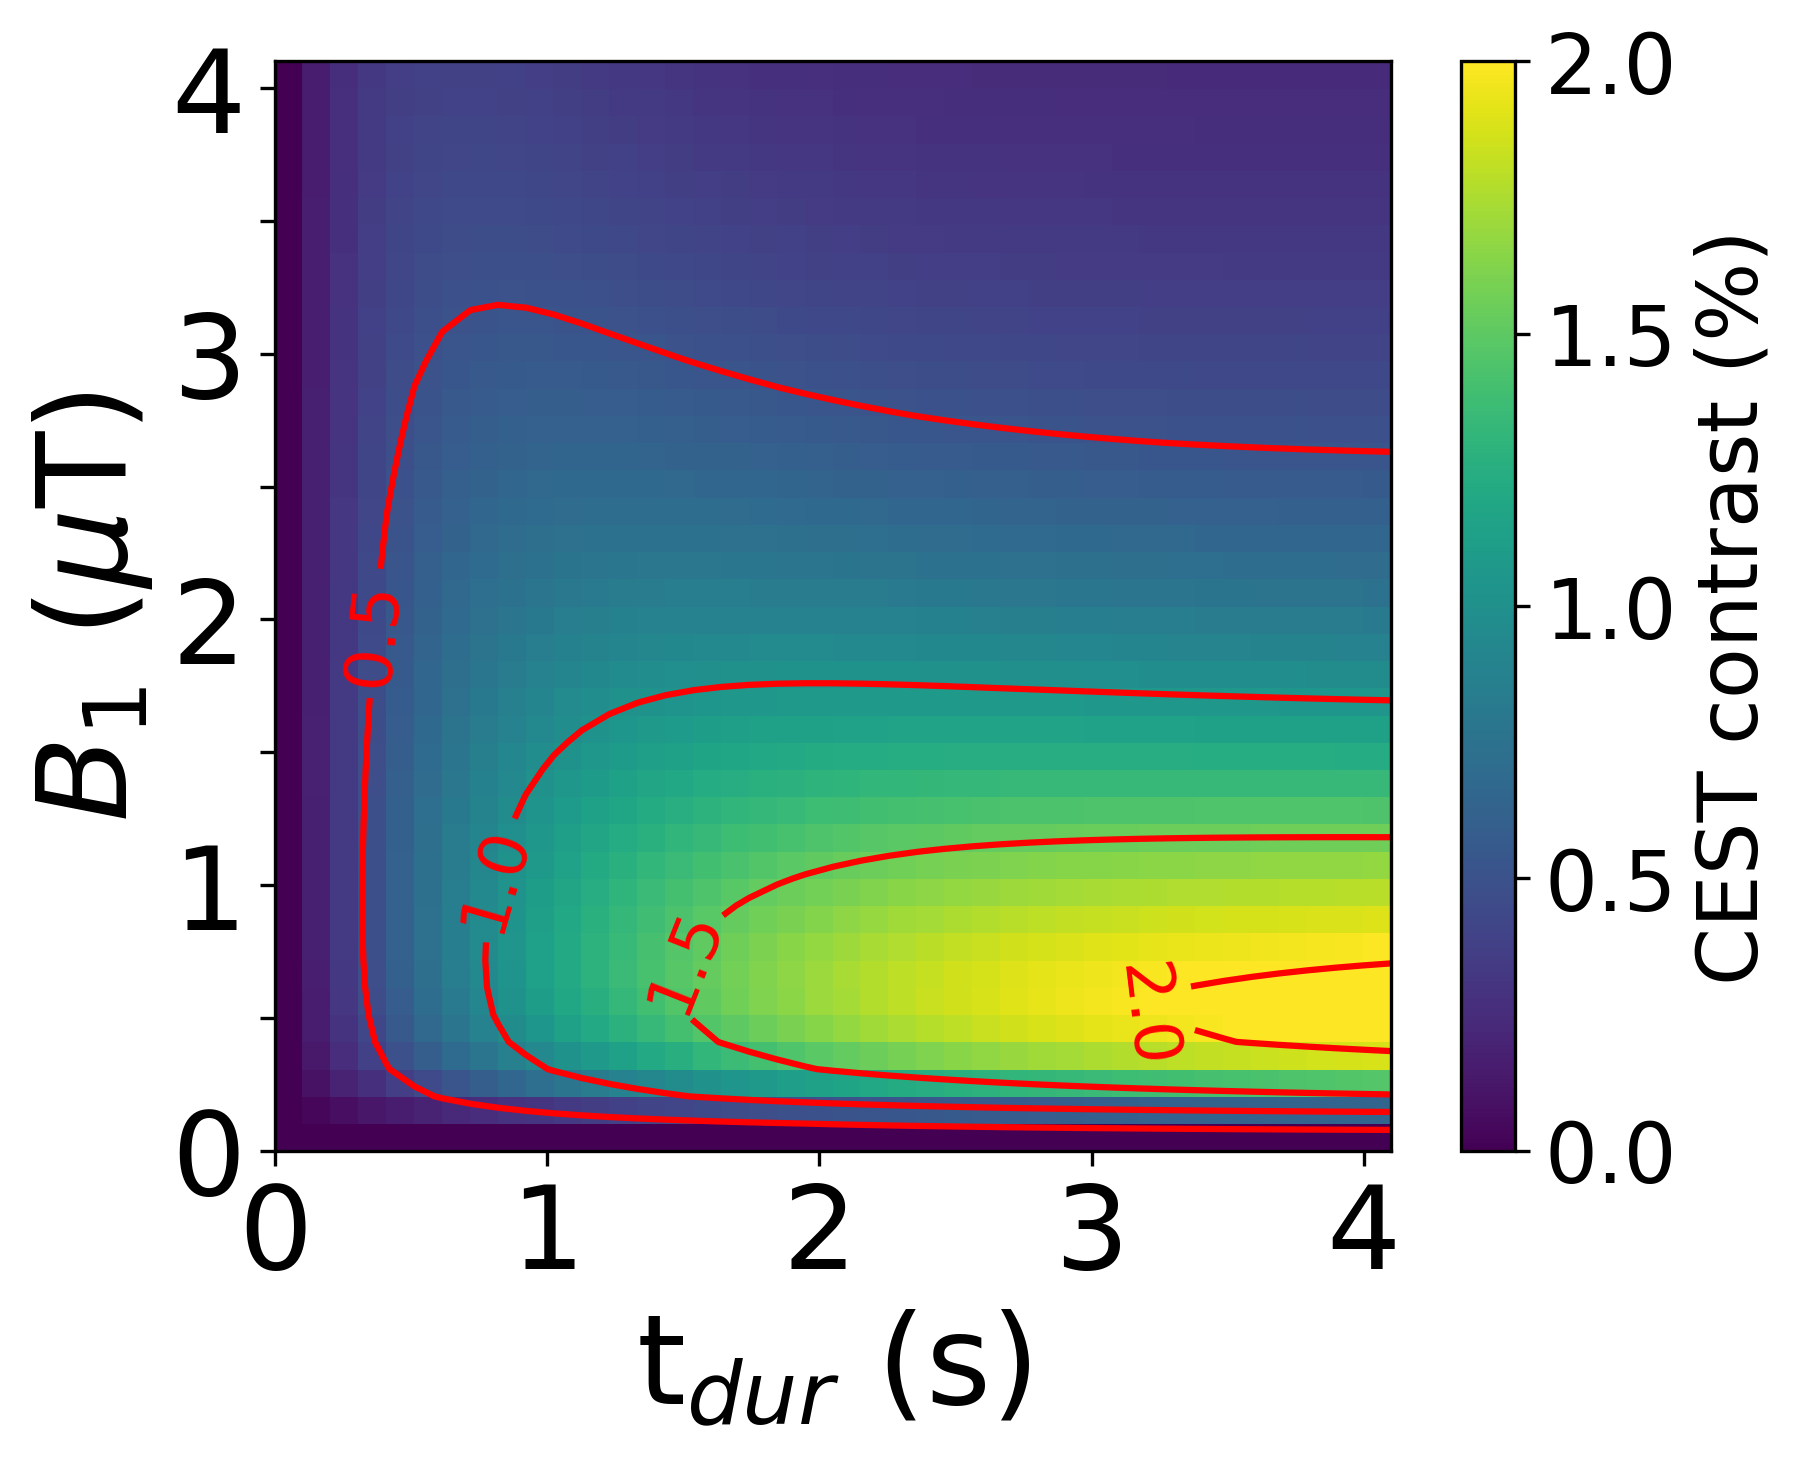

In [12]:
# contourf(X, Y, max_contrast[2], 5, cmap='RdGy')
fig, ax = plt.subplots(figsize=(6,4.81),dpi=300)


contours = plt.contour(X, Y, 100*max_contrast[2], 4, colors='r')
plt.clabel(contours, inline=True, fmt='%1.1f',fontsize=16)

im = ax.pcolormesh(X, Y, 100*max_contrast[2], vmin=0, vmax=2)
# cbar = fig.colorbar(im, ticks=[0, 0.5, 1, 1.5, 2])
cbar = fig.colorbar(im, ticks=[0, 0.5, 1, 1.5, 2])
cbar.ax.tick_params(labelsize=20) 
cbar.set_label('CEST contrast (%)', fontsize=20)

y_label_list = ['0','','1','','2','','3','','4']
ax.set_yticklabels(y_label_list, fontsize=28)


x_label_list = ['0','1','2','3','4']
ax.set_xticklabels(x_label_list, fontsize=28)

plt.ylabel('$B$$_{1}}$ ($\mu$T)', fontsize=30)
plt.xlabel('t$_{dur}}$ (s)', fontsize=30)
# plt.title('saturation efficiency ($\\alpha$)', fontsize=25)
# l(r'$\lambda$')

plt.show()

In [13]:
# fig,ax0 = plt.subplots(figsize=(5,4), dpi=300)

# ax0.plot(cestFreq,simulationMatrix[0,10,10,:],'k-',linewidth=3, label='with interested signal')
# ax0.plot(cestFreq,simulationMatrix[3,10,10,:],'b-',linewidth=3, label='without interested signal')

# ax0.plot(cestFreq,simulationMatrix[0,39,10,:],'k-',linewidth=3, label='with interested signal')
# ax0.plot(cestFreq,simulationMatrix[3,39,10,:],'b-',linewidth=3, label='without interested signal')

# ax0.set_xlim(cestFreq.max(), cestFreq.min())
# ax0.set_ylim(0,1.)
# ax0.set_ylabel('S$_s$$_a$$_t$/S$_0$', Fontsize = 20)
# ax0.tick_params(labelsize=15)
# ax0.set_xlabel('Saturation Frequency (ppm)', fontsize = 20)
# # legend(framealpha=0.0)

# ax1=ax0.twinx()
# ax1.plot(cestFreq, differenceMatrix[2,10,10,:]*100,'r-',linewidth=3, label='differencce')
# ax1.plot(cestFreq, differenceMatrix[2,39,10,:]*100,'g-',linewidth=3, label='differencce')
    
# ax1.set_xlim(cestFreq.max(), cestFreq.min())
# ax1.set_ylim(0, 8)
# ax1.set_xlabel('Saturation Frequency (ppm)', fontsize = 20)
# ax1.set_ylabel('Signal (%)', Fontsize = 20)
# ax1.tick_params(labelsize=15)            
# # legend(framealpha=0.0)

# Cr

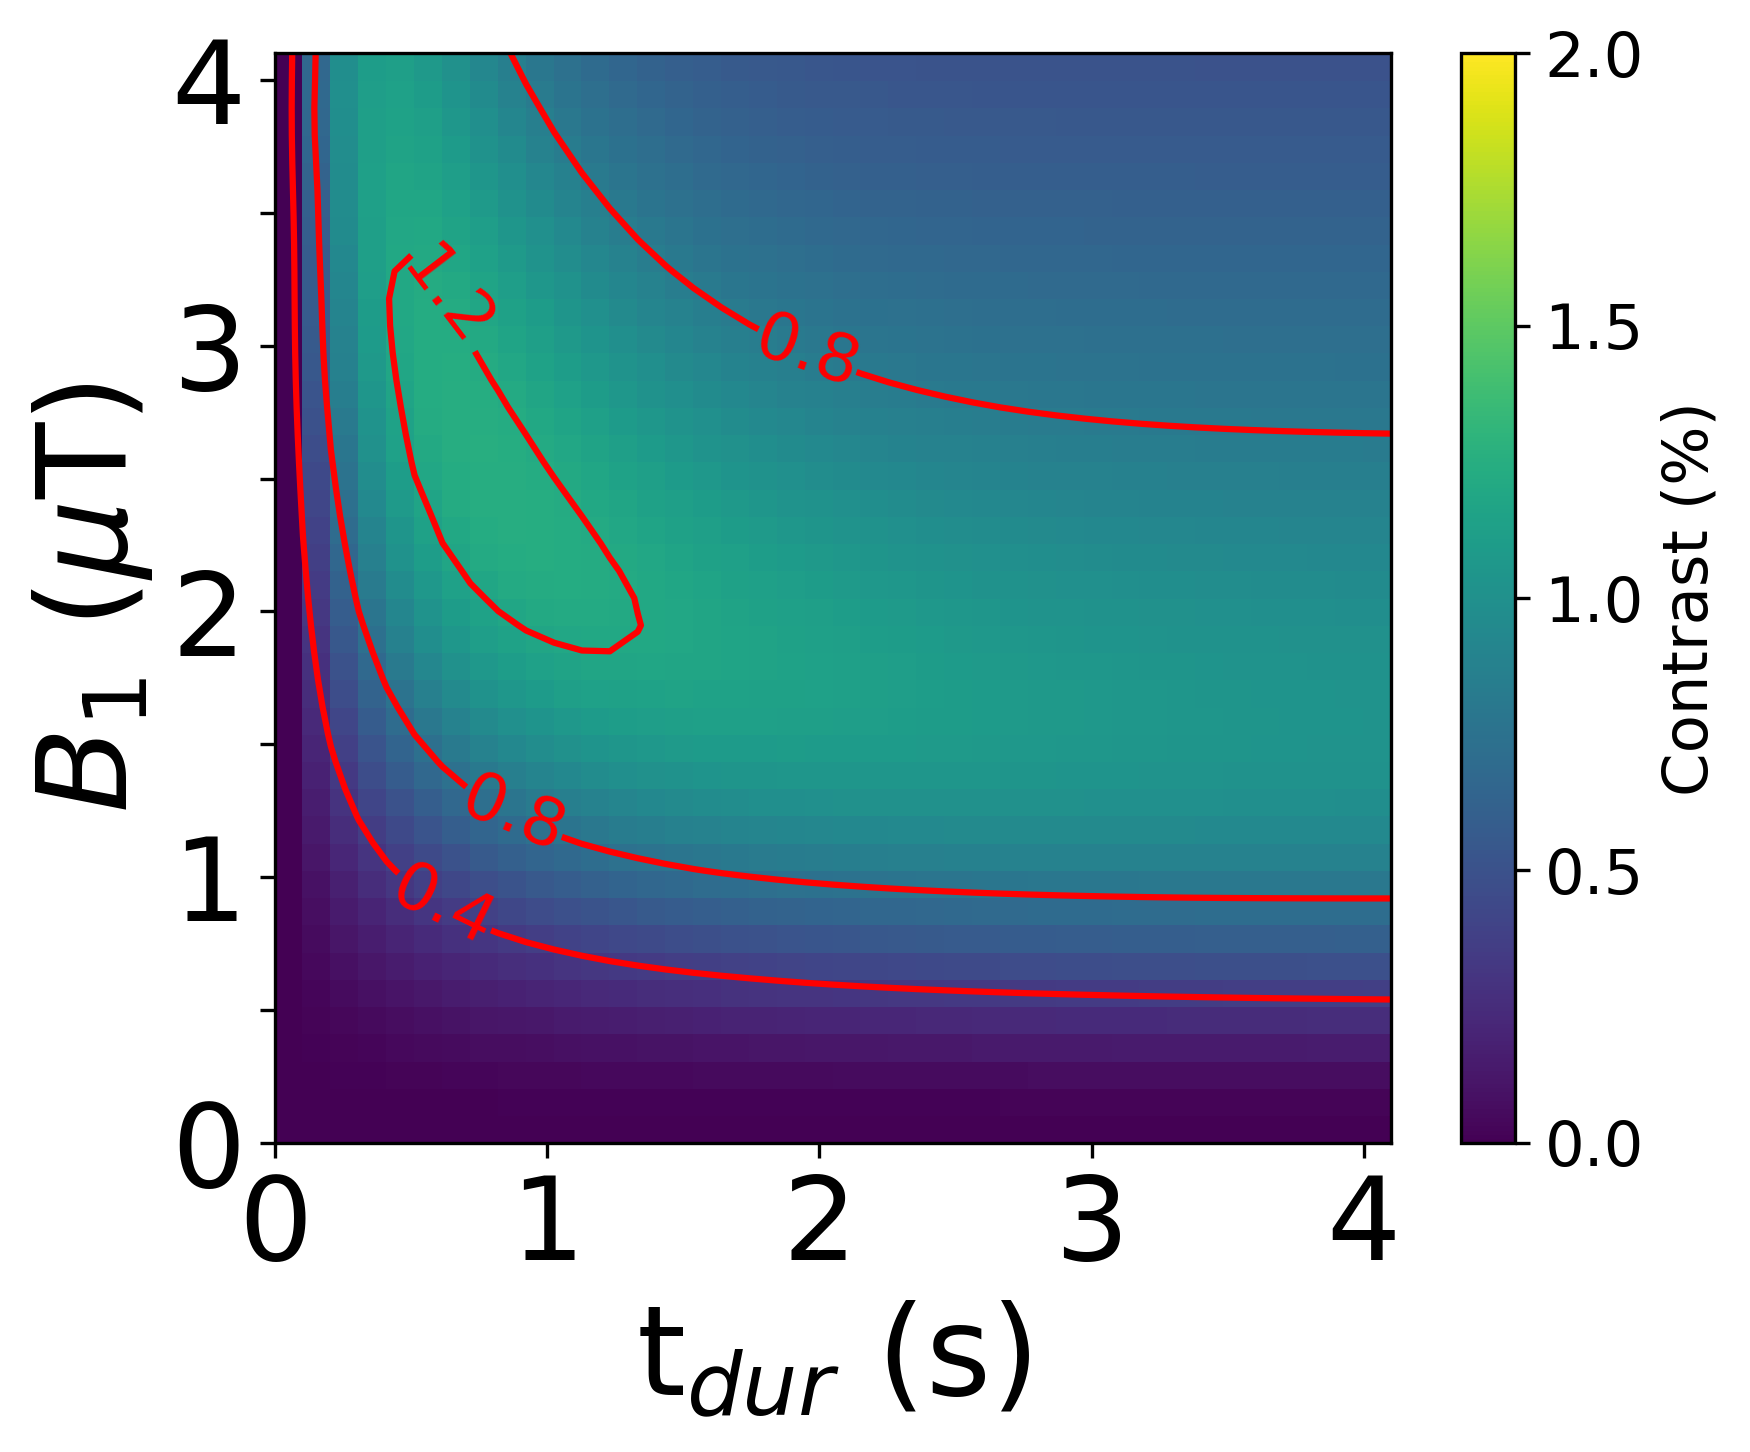

In [14]:
# contourf(X, Y, max_contrast[2], 5, cmap='RdGy')
fig, ax = plt.subplots(figsize=(6,4.81),dpi=300)


contours = plt.contour(X, Y, 100*max_contrast[3], 3, colors='r')
plt.clabel(contours, inline=True, fmt='%1.1f',fontsize=16)

im = ax.pcolormesh(X, Y, 100*max_contrast[3], vmin=0, vmax=2)
cbar = fig.colorbar(im, ticks=[0, 0.5, 1, 1.5, 2])
cbar.ax.tick_params(labelsize=15) 
cbar.set_label('Contrast (%)', fontsize=15)

y_label_list = ['0','','1','','2','','3','','4']
ax.set_yticklabels(y_label_list, fontsize=28)


x_label_list = ['0','1','2','3','4']
ax.set_xticklabels(x_label_list, fontsize=28)

plt.ylabel('$B$$_{1}}$ ($\mu$T)', fontsize=30)
plt.xlabel('t$_{dur}}$ (s)', fontsize=30)
# plt.title('saturation efficiency ($\\alpha$)', fontsize=25)
# l(r'$\lambda$')

plt.show()


In [15]:
# fig,ax0 = plt.subplots(figsize=(5,4), dpi=300)

# ax0.plot(cestFreq,simulationMatrix[0,30,10,:],'k-',linewidth=3, label='with interested signal')
# ax0.plot(cestFreq,simulationMatrix[4,30,10,:],'b-',linewidth=3, label='without interested signal')

# ax0.plot(cestFreq,simulationMatrix[0,30,39,:],'k-',linewidth=3, label='with interested signal')
# ax0.plot(cestFreq,simulationMatrix[4,30,39,:],'b-',linewidth=3, label='without interested signal')

# ax0.set_xlim(cestFreq.max(), cestFreq.min())
# ax0.set_ylim(0,1.)
# ax0.set_ylabel('S$_s$$_a$$_t$/S$_0$', Fontsize = 20)
# ax0.tick_params(labelsize=15)
# ax0.set_xlabel('Saturation Frequency (ppm)', fontsize = 20)
# # legend(framealpha=0.0)

# ax1=ax0.twinx()
# ax1.plot(cestFreq, differenceMatrix[3,30,10,:]*100,'r-',linewidth=3, label='differencce')
# ax1.plot(cestFreq, differenceMatrix[3,30,39,:]*100,'g-',linewidth=3, label='differencce')
    
# ax1.set_xlim(cestFreq.max(), cestFreq.min())
# ax1.set_ylim(0, 8)
# ax1.set_xlabel('Saturation Frequency (ppm)', fontsize = 20)
# ax1.set_ylabel('Signal (%)', Fontsize = 20)
# ax1.tick_params(labelsize=15)            
# # legend(framealpha=0.0)